# Analisador de Fake News


## Problemática
O atual cenário político-social mundial tem se mostrado fortemente impactado pela **disseminação de Fake News**, as quais vem ganhando bastante **notoriedade com o crescente uso de redes sociais** e divulgação das mesmas nesses meios.

Visto que as fakes news **acabam servindo como um meio de alienar a população**, o presente notebook possui o objetivo de **elaborar um modelo que possa classificar se determinada notícia é verdadeira ou falsa**, consistindo **ao todo em 4009 registros de notícias**, sendo 2137 notícias falsas e 1872 notícias verdadeiras.

Aqui utilizaremos os seguintes algoritmos de aprendizagem de máquina para elaboração do nosso modelo:
> - Regressão Logística
> - KNN
> - Análise Discriminante Gaussiano
> - Árvore de Decisão

## Fonte dos Dados
O dataset utilizado para este problema foi retirado do [Kaggle]( https://www.kaggle.com/jruvika/fake-news-detection), fruto de um web crawler de diferentes fontes americanas, consiste em **4009 registros de notícias**, sendo **2137 notícias falsas** e **1872 notícias verdadeiras**.

## Sumário
#### 1. Importações
#### 2. Leitura dos Dados
#### 3. Limpeza e Transformações dos Dados
#### 4. Redução de Dimensionalidade dos Dados
#### 5. Visualizações dos dados
#### 6. Avaliação dos Modelos

# 1. Importações

In [1]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sb
from statistics import mean
from scipy.linalg import svd 
from math import log, pi, sqrt
import matplotlib.pyplot as plt
from operator import itemgetter
%matplotlib inline

# Tratamento do Texto
from textblob import TextBlob, Word
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from scipy.linalg import svd 
from sklearn import linear_model, datasets, svm, metrics
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import DistanceMetric, KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
# from modelos import distance_euclidian, distance_manhattan, fitAD, fitAGD, fitRF, fitRL, fitSVM, getClasses, predict1AGD, predict1KNN, predictAD, predictAGD, predictKNN, predictRF, predictRL, predictSVM, sigmoide 
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
stop = stopwords.words('english')
warnings.filterwarnings("ignore")
np.random.seed(12345)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 2. Leitura dos Dados

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
dataset = pd.read_csv("/content/drive/My Drive/Profissional/Palestras/MachineLearning/Aula3/data.csv") # será utilizado para computar coisas nas visualizações
dataset['Body'] = dataset['Body'].astype(str) 
data = dataset # será limpado e utilizado nos modelos
data.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\r\nOn Sunday morn...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


# 3. Limpeza dos Dados

In [9]:
# Deixar tudo em lower case
data['Headline'] = data['Headline'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['Body'] = data['Body'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
# Removendo pontuação
data['Headline'] = data['Headline'].str.replace('[^\w\s]','')
data['Body'] = data['Body'].str.replace('[^\w\s]','')
# Removendo stopwords
data['Headline'] = data['Headline'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['Body'] = data['Body'].apply(lambda x: " ".join(x for x in str(x).split() if str(x) not in stop))
# 10 Palavras mais frequentes e menos frequentes
freqHeadline = pd.Series(' '.join(data['Headline']).split()).value_counts()[:10]
freqBody = pd.Series(' '.join(data['Body']).split()).value_counts()[:10]
rareHead = pd.Series(' '.join(data['Headline']).split()).value_counts()[-10:]
rareBody = pd.Series(' '.join(data['Body']).split()).value_counts()[-10:]
# Remoção das palavras raras e frequentes
freqHeadline = list(freqHeadline.index)
freqBody = list(freqBody.index)
data['Headline'] = data['Headline'].apply(lambda x: " ".join(x for x in x.split() if x not in freqHeadline))
data['Body'] = data['Body'].apply(lambda x: " ".join(x for x in x.split() if x not in freqBody))
data['Headline'] = data['Headline'].apply(lambda x: " ".join(x for x in x.split() if x not in rareHead))
data['Body'] = data['Body'].apply(lambda x: " ".join(x for x in x.split() if x not in rareBody))
# Lemmatization. Extrai o núcleo/root da palavra
data['Headline'] = data['Headline'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data['Body'] = data['Body'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data.head()

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,four way bob corker skewered donald,image copyright getty image sunday morning don...,1
1,https://www.reuters.com/article/us-filmfestiva...,linklaters war veteran comedy speaks modern am...,london reuters last flag flying comedydrama vi...,1
2,https://www.nytimes.com/2017/10/09/us/politics...,trump fight corker jeopardizes legislative agenda,feud broke public view last week mr corker mr ...,1
3,https://www.reuters.com/article/us-mexico-oil-...,egypt cheiron win tieup pemex mexican onshore ...,mexico city reuters egypt cheiron holding limi...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,jason aldean open snl tribute,country singer jason aldean performing la vega...,1


In [10]:
vectorizer = CountVectorizer()
vectorizer.fit(data['Headline']) # tokenize and build vocabulary
vector = vectorizer.transform(data['Headline']) # encode document
print("Tamanho: ", vector.shape)
head = [key for key in  vectorizer.vocabulary_]
df = pd.DataFrame(vector.toarray(), columns = head)
df['Label'] = data['Label']
df.head()

Tamanho:  (4009, 6634)


,four,way,bob,corker,skewered,donald,linklaters,war,veteran,comedy,speaks,modern,america,star,trump,fight,jeopardizes,legislative,agenda,egypt,cheiron,win,tieup,pemex,mexican,onshore,oil,field,jason,aldean,open,snl,tribute,jetnation,fanduel,league,kansa,tried,tax,plan,...,movil,separation,aviation,niagara,cited,sewage,discharge,opioids,walmart,timesaving,basket,pickup,highly,ranked,sooner,holly,clyburn,cristie,kerr,dumb,aldeon,foreknowledge,glencore,pip,sinopec,chevron,granted,margo,nashville,outsider,tragic,hervé,leroux,léger,bandage,dress,30minute,100000,antiamerican,Label
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# 4. Redução da Dimensionalidade

In [11]:
def fisher_score(x, y):
    mean = np.mean(x, axis=0)
    classes = np.unique(y)
    sS = 0
    sD = 0
    Nk = []
    
    meanD = []
    varD = []
    
    for k in classes:
        elements = []
        s = 0
        for i in range(0, len(y)):
            if(y[i] == k):
                s += 1
                elements.append(x[i])
        meanD.append(np.mean(elements, axis=0))
        varD.append(np.var(elements, axis=0))
        Nk.append(s)
    
    for k in range(0, len(classes)):
        sS += (Nk[k] * ((meanD[k] - mean)**2))
        sD += (Nk[k] * varD[k])
    return sS/sD

def compute(x):
    mean = np.mean(x, axis = 0)
    cov = np.cov(np.transpose(x))

    U, S, V = svd(cov)
    S = np.diag(S)
    M = U @ S @ V
    P = np.transpose(U)
    return {'S': S, 'U': U, 'V': V, 'M': M, 'P': P}

def transform(x, rateVariance):
    pca_result = compute(x)
    
    S = pca_result['S']
    P = pca_result['P']
    
 #   autovalores = np.sort([S[i][i] for i in range(len(S))])[::-1]
    #varianciaExplicadaTot = np.sum(np.array(autovalores))
    #varianceExpl = rateVarience*varianciaExplicadaTot

    #matrizTransform = []
    
    matrizTransform = []
    varianciaExplicadaTot = 0
    varianceExpl = 0
    autoValores = []
    for i in range(0, S.shape[0]):
        varianciaExplicadaTot += S[i,i]
        autoValores.append(S[i,i])
    varianceExpl = rateVariance *varianciaExplicadaTot

    autoValOrdenados = np.sort(autoValores)
    autoValOrdenados = autoValOrdenados[::-1]
    
    varianceAtual = 0
    i = 0
    while(varianceAtual<=varianceExpl and i<autoValOrdenados.shape[0]):
        for j in range (0, len(autoValores)):
            if(autoValOrdenados[i]==autoValores[j]):
                matrizTransform.append(P[j])
        varianceAtual += autoValOrdenados[i]
        i += 1
    return {'P': matrizTransform, 'Z':np.transpose(np.dot(matrizTransform, np.transpose(x)))}

In [12]:
resultPCA = transform(df.values[:,0:-1], 0.9)

In [13]:
dataPCA = np.hstack((resultPCA['Z'], df.values[:,-1][:,None]))
matrizPCA = resultPCA['P']

In [14]:
fisher_scores = fisher_score(dataPCA[:,0:-1], dataPCA[:,-1])
qnt = 1000 # quantas colunas quer dropar pelo fisher score
indices = [] # armazena os indices dos menores valores do fisher_score -> que é o que vamos dropar
for i in range(qnt): # faz o processamento de armazenar os indices dos menores valores
    indice = np.argmin(fisher_scores)
    fisher_scores[indice] = 10000
    indices.append(indice)

dataPCA = pd.DataFrame(dataPCA)
data_fisher = dataPCA.drop([dataPCA.columns[i] for i in indices] ,  axis='columns')
data_fisher.head()
#classes, ocorrencs = np.unique(indices, return_counts=True)
#dict(zip(classes, ocorrencs))

,0,1,2,3,4,5,6,9,10,11,13,14,15,17,18,19,20,21,22,23,24,25,26,27,31,32,33,34,35,39,40,41,43,44,45,46,49,50,51,53,...,1232,1241,1257,1263,1264,1266,1269,1273,1274,1279,1284,1286,1287,1290,1293,1295,1301,1302,1305,1308,1309,1321,1336,1339,1343,1353,1359,1365,1376,1384,1385,1392,1394,1395,1399,1409,1417,1431,1442,1444
0,0.025690,-0.024910,-0.033510,-0.035610,-0.020001,0.013184,-0.043947,-0.347851,-0.115924,-0.209082,-0.040723,-0.025682,-0.053207,-0.029683,0.013519,-0.012527,0.013273,-0.011334,-0.008116,-0.023637,-0.011734,0.047161,0.042451,0.008355,-0.034742,-0.068248,-0.013363,0.040783,-0.026032,0.034073,-0.115392,0.047294,-0.015186,-0.131308,0.013712,-0.052603,-0.041980,-0.153553,-0.120075,0.133493,...,0.006747,0.004587,0.009178,-0.021582,-0.017183,-0.014481,-0.067832,-0.002893,0.004158,0.008175,0.009210,-0.035941,-0.011972,0.055754,-0.019969,-0.025256,0.022478,0.002065,-0.027624,-0.014255,-0.012569,-0.015846,0.000609,0.056065,0.001871,-0.020997,-0.003585,0.000248,-0.000802,0.016014,-0.027547,0.013410,-0.012507,0.012874,-0.001875,0.007450,-0.015722,-0.007338,-0.002936,1.0
1,-0.027008,-0.010449,-0.018232,0.002831,-0.020735,0.010256,-0.005489,-0.087276,-0.024951,0.015848,-0.105659,-0.176450,-0.141038,-0.029982,-0.043444,-0.015079,-0.010407,-0.011430,-0.066636,0.001837,0.013727,-0.036703,-0.012656,0.007026,0.025385,0.030491,-0.008757,-0.029376,-0.149945,-0.164198,-0.262329,0.436733,0.362051,-0.409929,0.004197,-0.013852,0.110459,-0.384805,0.248711,0.181856,...,0.029785,-0.038623,0.012899,0.013571,0.043724,0.024276,0.042498,-0.015788,0.016090,-0.019333,0.029744,0.046773,-0.022226,0.047361,0.011200,-0.002329,0.085047,-0.005930,0.003318,-0.015468,-0.050139,-0.035755,-0.041150,-0.028522,-0.009288,-0.014958,0.001621,0.002162,-0.007041,0.016329,0.024476,-0.031195,-0.045033,0.013792,-0.002053,-0.001811,0.022194,0.018410,-0.014542,1.0
2,-0.030488,-0.036353,-0.050297,0.012334,-0.020427,-0.060536,-0.003552,-0.513533,-0.174059,-0.247496,-0.009688,0.118110,0.028594,0.020761,-0.002453,0.021356,-0.046604,-0.001319,0.003462,0.010967,-0.055523,0.034840,0.034877,0.008044,0.023449,0.056988,0.140832,-0.089011,-0.006668,0.033770,-0.014304,0.035398,0.044588,0.010864,0.079332,-0.046855,-0.163624,0.014525,0.094962,-0.035059,...,-0.028189,-0.019778,0.041773,0.003059,-0.047782,0.027117,-0.002479,0.018574,0.097196,0.012542,0.004024,0.024879,0.068471,-0.030247,0.007619,0.039566,0.073472,0.054278,-0.028702,0.010967,-0.036202,-0.111953,0.069697,-0.031092,0.031289,-0.037241,-0.046798,0.049026,-0.046248,-0.095189,0.003649,-0.011925,-0.023045,0.014783,0.001961,-0.100768,0.054847,0.025333,0.030703,1.0
3,0.748007,0.052081,0.001537,0.219593,-0.554923,-0.049215,0.136251,0.171218,-0.225118,-0.102917,0.014899,-0.038004,0.004938,0.092391,0.077996,0.014751,0.018768,-0.043495,-0.001539,0.036817,0.028034,-0.000847,-0.086639,-0.058902,-0.028684,-0.001512,-0.065818,-0.004828,0.008169,0.041823,0.045955,0.068499,-0.009999,0.077956,0.015019,-0.095188,-0.033907,0.018855,-0.013427,-0.012581,...,-0.032069,-0.033504,-0.019064,0.031658,0.033160,0.034629,-0.039198,-0.007032,0.076910,-0.007557,0.035222,0.015687,0.106797,-0.029553,-0.040155,-0.001949,-0.058149,0.016880,0.027690,-0.001816,0.000871,-0.027412,-0.008695,-0.030741,-0.020591,0.002196,0.007980,-0.012451,-0.065575,0.078775,-0.003692,0.015550,-0.018488,0.049480,-0.065821,0.009455,0.001164,-0.014068,-0.013595,1.0
4,-0.017513,-0.019154,-0.030957,0.002869,-0.008999,-0.039631,0.032431,0.058959,-0.003062,0.023747,-0.033756,0.019258,0.012284,-0.000447,0.073045,0.020711,-0.077931,-0.046623,0.181811,-0.007562,0.174143,0.066789,0.145402,-0.167816,0.402183,0.024557,-0.125329,0.152381,-0.420819,0.276054,-0.207751,0.147670,0.001705,-0.183033,-0.169636,0.304631,-0.135951,-0.284133,0.170733,-0.284144,...,0.019913,-0.012447,0.017383,-0.009382,-0.019610,-0.003718,0.010993,0.004306,-0.017600,-0.007472,-0.001192,-0.006755,-0.024652,-0.013611,0.016615,0.028746,0.015869,-0.004596,-0.000551,-0.003033,-0.020010,0.025807,-0.001944,-0.006815,-0.002056

# 5. Visualização e Análise dos dados

0. dataset.describe()
0. dataset.corr()

0. WordCloud

1. Palavras mais frequentes por classe - sem stopwords - (grafico de barras)
2. Palavras menos frequentes por classe - sem stopwords - (grafico de barras)



In [15]:
#usar dataset pós-limpeza
dataset = data

titulosFake = ""
titulosReal = ""
for i in range(0, dataset.shape[0]):
    if (dataset['Label'][i]==1):
        titulosFake += dataset['Headline'][i]+" "
    else:
        titulosReal += dataset['Headline'][i]+" "

In [16]:
wordsFake = titulosFake.split()
wordsReal = titulosReal.split()

distinctFake = []
distinctReal = []
for i in wordsFake:
    if i not in distinctFake:
        distinctFake.append(i)
for i in wordsReal:
    if i not in distinctReal:
        distinctReal.append(i)


countFake = []
countReal = []
for i in distinctFake:
    cont = 0
    for j in wordsFake:
        if (i==j):
            cont += 1
    countFake.append(cont)
for i in distinctReal:
    cont = 0
    for j in wordsReal:
        if (i==j):
            cont += 1
    countReal.append(cont)
    
dictFake = {}
for i in range(0, len(distinctFake)):
    dictFake[distinctFake[i]] =  countFake[i]
    
dictFake = sorted(dictFake.items(), key=itemgetter(1), reverse=True)

dictReal = {}
for i in range(0, len(distinctReal)):
    dictReal[distinctReal[i]] =  countReal[i]

dictReal = sorted(dictReal.items(), key=itemgetter(1), reverse=True)

wordsFake = []
wordsReal = []
contFake = []
contReal = []
for i in range(0, 15):
    wordsFake.append(dictFake[i][0])
    contFake.append(dictFake[i][1])
    wordsReal.append(dictReal[i][0])
    contReal.append(dictReal[i][1])

## 5.1. WordCloud Fake News

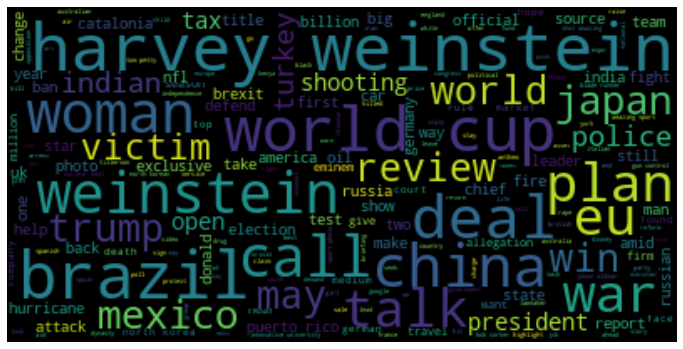

In [17]:
wordcloud = WordCloud(max_font_size=100).generate(titulosFake)
plt.figure(figsize=(12,8)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('WordCloudtMostFrequencyFakeNews.png')
plt.show()


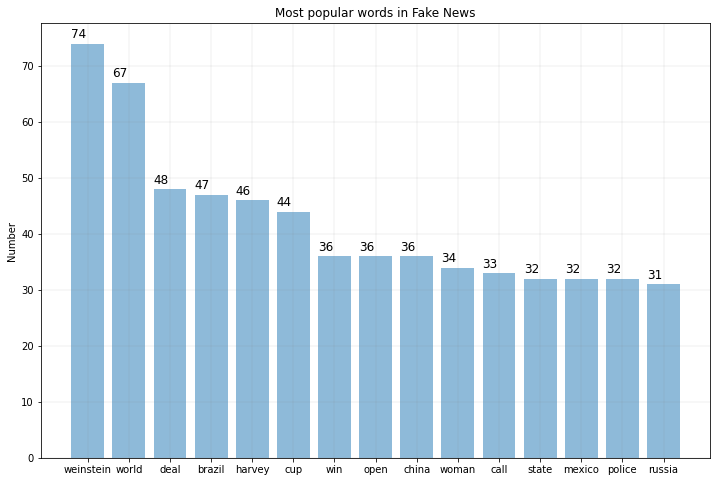

In [18]:
plt.figure(figsize=(12,8)) 
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
#plt.bar(wordsFake, contFake, color="blue")
rects = plt.bar(wordsFake, contFake, align='center', alpha=0.5)
plt.ylabel('Number')
plt.title('Most popular words in Fake News')
for bar in rects:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval+1, yval, fontsize=12)
plt.savefig('BarChartMostFrequencyFakeNews.png')
plt.show()


## 5.2. WordCloud Notícias Reais

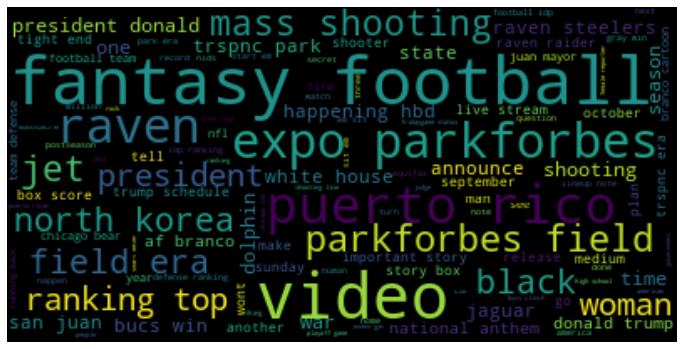

In [19]:
wordcloud = WordCloud(max_font_size=100).generate(titulosReal)
plt.figure(figsize=(12,8)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('WordCloudtMostFrequencyRealNews.png')
plt.show()


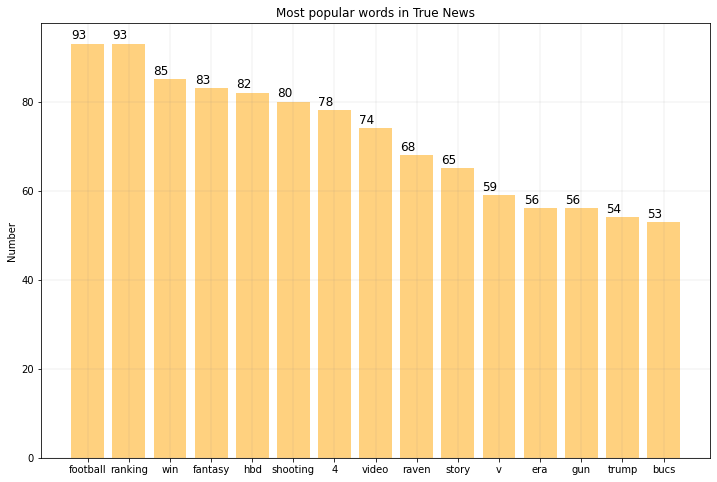

In [20]:
#plt.bar(wordsReal, contReal, color="red")

plt.figure(figsize=(12,8)) 
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
#plt.bar(wordsFake, contFake, color="blue")
rects = plt.bar(wordsReal, contReal, align='center', alpha=0.5, color = "orange")
plt.ylabel('Number')
plt.title('Most popular words in True News')
for bar in rects:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval+1, yval, fontsize=12)
plt.savefig('BarChartMostFrequencyRealNews.png')
plt.show()


# 6. Avaliação de Métodos

In [21]:
# Split dos Dados
# atribuindo X com as features e y com os valores de classe
X = data_fisher.values[:,:-1]
Y = data_fisher.values[:,-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

In [22]:
def acc(y_test, results):
    tot = [1 for x,z in zip(y_test,results) if x == z]
    return (np.sum(np.array(tot))/len(y_test))*100

## 6.1 Regressão Logística

In [23]:
logreg = linear_model.LogisticRegression(C = 5)
logreg.fit(x_train, y_train)
predictedRL = logreg.predict(x_test)
score = accuracy_score(y_pred = predictedRL, y_true = y_test)
score

0.8793619142572283

In [24]:
print(classification_report(y_test, predictedRL))

              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89       529
         1.0       0.88      0.86      0.87       474

    accuracy                           0.88      1003
   macro avg       0.88      0.88      0.88      1003
weighted avg       0.88      0.88      0.88      1003



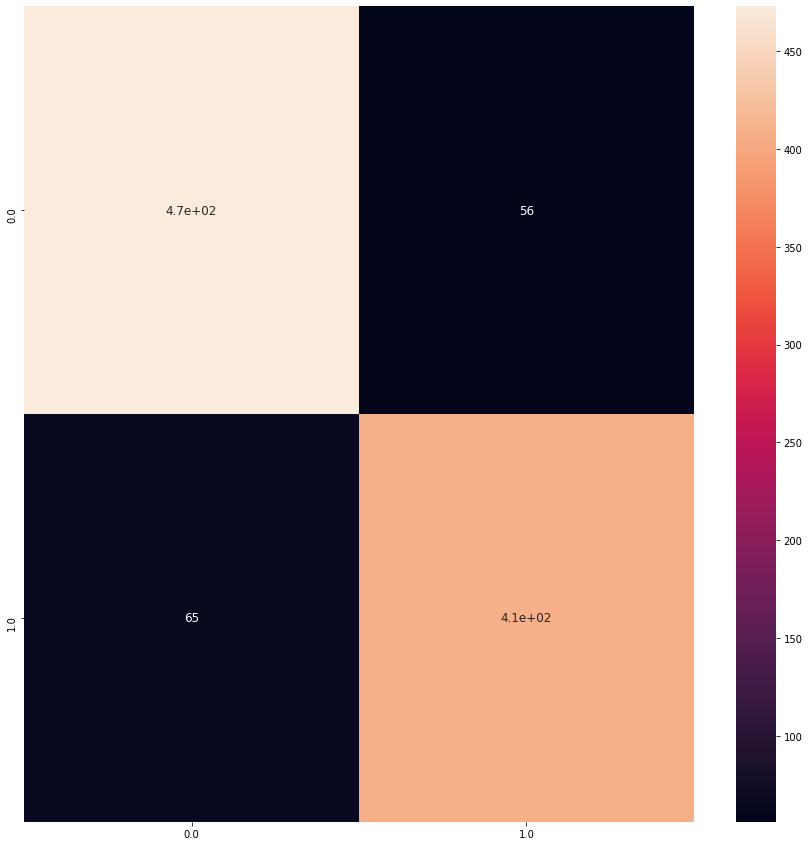

In [25]:
cm = confusion_matrix(y_test, predictedRL)
cm_df = pd.DataFrame(cm, index = np.unique(y_test), columns = np.unique(y_test))

plt.figure(figsize=(15,15))
sb.heatmap(cm_df, annot=True, annot_kws={"size": 12})
plt.savefig('RegLog.png')

## 6.2. Análise Discriminante Gaussiano

In [26]:
clf = GaussianNB()
clf.fit(x_train, y_train)
predictedNB = clf.predict(x_test)
score = accuracy_score(y_pred = predictedNB, y_true = y_test)
score

0.6929212362911267

In [27]:
print(classification_report(y_test, predictedNB))

              precision    recall  f1-score   support

         0.0       0.74      0.64      0.69       529
         1.0       0.65      0.75      0.70       474

    accuracy                           0.69      1003
   macro avg       0.70      0.70      0.69      1003
weighted avg       0.70      0.69      0.69      1003



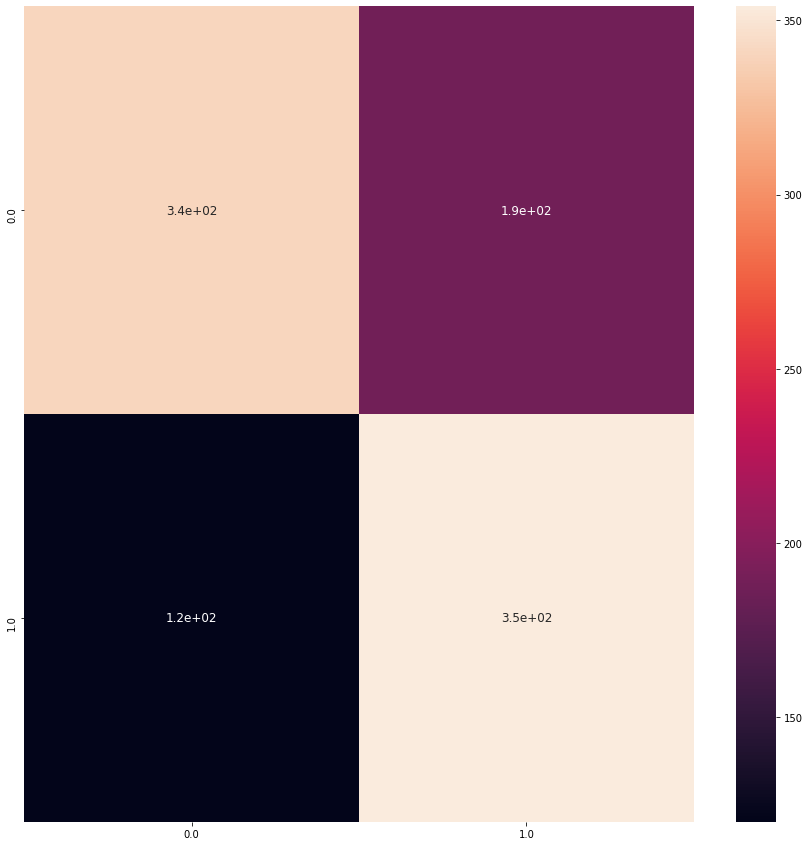

In [28]:
cm = confusion_matrix(y_test, predictedNB)
cm_df = pd.DataFrame(cm, index = np.unique(y_test), columns = np.unique(y_test))

plt.figure(figsize=(15,15))
sb.heatmap(cm_df, annot=True, annot_kws={"size": 12})
plt.savefig('AGD.png')

## 6.3. Árvore de Decisão

In [29]:
tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(x_train, y_train)
predictedAD = tree_classifier.predict(x_test)
score = accuracy_score(y_pred = predictedAD, y_true = y_test)
score


0.7537387836490529

In [30]:
print(classification_report(y_test, predictedAD))

              precision    recall  f1-score   support

         0.0       0.75      0.80      0.77       529
         1.0       0.76      0.70      0.73       474

    accuracy                           0.75      1003
   macro avg       0.75      0.75      0.75      1003
weighted avg       0.75      0.75      0.75      1003



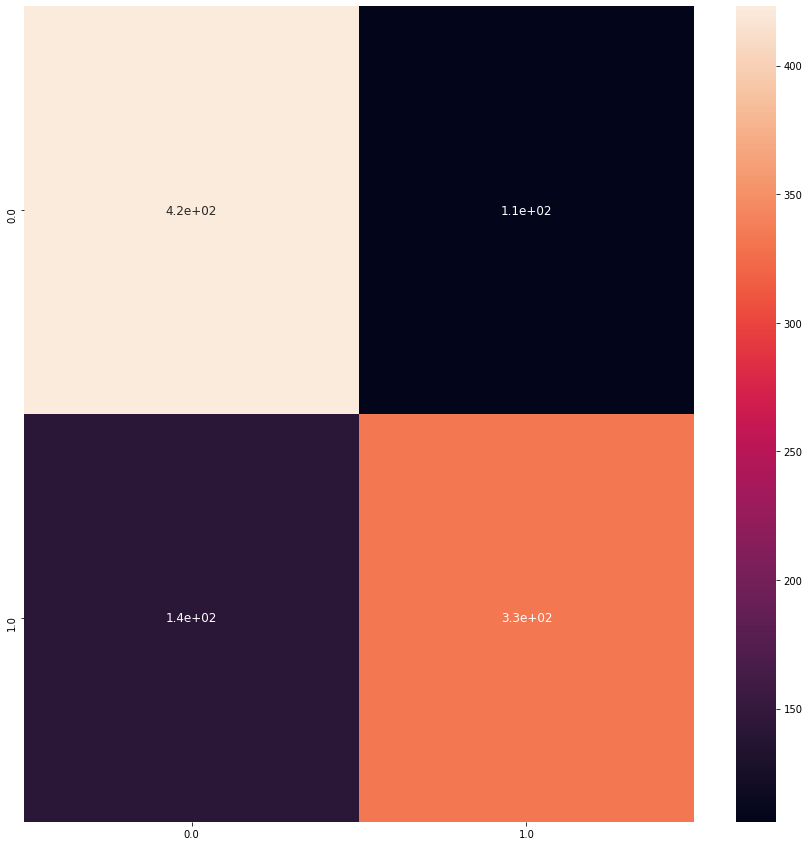

In [31]:
cm = confusion_matrix(y_test, predictedAD)
cm_df = pd.DataFrame(cm, index = np.unique(y_test), columns = np.unique(y_test))

plt.figure(figsize=(15,15))
sb.heatmap(cm_df, annot=True, annot_kws={"size": 12})
plt.savefig('AD.png')

## 6.6. KNN

In [32]:
dist = DistanceMetric.get_metric('euclidean')
knn = KNeighborsClassifier(n_neighbors = 3, metric='euclidean')

# treinando o modelo com os conjuntos de treino
knn.fit(x_train, y_train)

# realizando a predicao
predictedKNN = knn.predict(x_test)
score = accuracy_score(y_pred = predictedKNN, y_true = y_test)
score

0.6879361914257228

In [33]:
print(classification_report(y_test, predictedKNN))

              precision    recall  f1-score   support

         0.0       0.66      0.85      0.74       529
         1.0       0.75      0.51      0.61       474

    accuracy                           0.69      1003
   macro avg       0.70      0.68      0.67      1003
weighted avg       0.70      0.69      0.68      1003



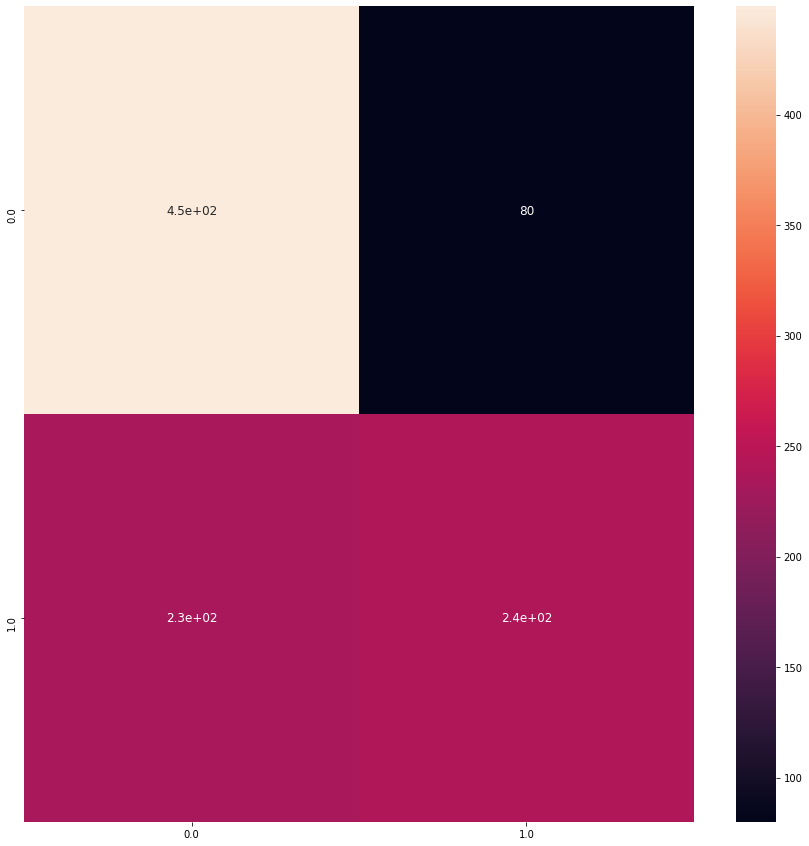

In [34]:
cm = confusion_matrix(y_test, predictedKNN)
cm_df = pd.DataFrame(cm, index = np.unique(y_test), columns = np.unique(y_test))

plt.figure(figsize=(15,15))
sb.heatmap(cm_df, annot=True, annot_kws={"size": 12})
plt.savefig('AD.png')